# Week 3
# Plotting a model of Disease Dynamics

# 1. Plotting Data and an Approximately Fitted Line Simultaneously

<h2>Outcome</h2>

After this lecture, you will be able to
- Explain how Julia's plot!() function differs from plot()
- Use plot!() to overlay a fitted curve to a scatter of data
- Modify the plot: adding labels, axis styles, line styles etc



<h2>Julia's modify-the-argument functions</h2>

A lovely feature of Julia is the convention of labelling modify-the-argument functions with an exclamation mark.

For example, consider the function fill!(), illustrated below.

In [5]:
tempvar = Array{Any}(undef, 4)
fill!(tempvar, "hello ... word")

4-element Array{Any,1}:
 "hello ... word"
 "hello ... word"
 "hello ... word"
 "hello ... word"

In [6]:
fill!(tempvar, 777)

4-element Array{Any,1}:
 777
 777
 777
 777

Let's just look at how the help system briefly, comparing these two functions and also looking at all functions starting with "a" and with "b" to see how many of the modify-in-place functions Julia has.

In [10]:
?b

search: big bind break begin Bool bswap Base BitSet BigInt binomial basename

Couldn't find b
Perhaps you meant !, %, &, *, +, -, /, :, <, >, \, ^, |, ~, ÷, π, ℯ, ∈, ∉ or ∋


No documentation found.

Binding `b` does not exist.


We see that quite a few functions have a plain form and an exclamation form. And many of the exclamation-ending-modify-in-place functions do things like add or remove values. They tend to be low level functions. The advantage of course is that as values are created they are written to space in memory that is already in use. This can speed up one's code significantly, and can also be important when your data sets are so large that memory efficiency becomes an issue.

<h2>The difference between "plot" and "plot!"</h2>

As we remarked, Plots is a package for using all the Julia plotting packages. The designer of Plots made the interesting choice (I think) to have only one active plot: if you want to make a different plot, you save your current plot and start on a new one. This simplifies the display of a plot. In our case, the notebook allows us to view different plots, because each plot is saved with its particular cell. In keeping with the idea of Plots, you cannot associate more than one plot with a cell.

So in general, if you call plot() a second time, it wipes out the old plot and draws a completely new one. But Plots *also* doesn't allow you to specify multiple different x-values for your plot. You can plot many different curves, as we did for the different countries' Ebola numbers (week 2, lecture 5), but only if they all use the same x-values.

To enable us to plot completely different curves, not only in style and colour and so on but also completely different x- and y-values, Plots gives us a function that modifies an existing plot. This function is plot!().

So the idea is the following: specify a plot for the first set of data using "plot()", and then specify, on the same plot, a second set of data by using "plot!"

<h2>An example: approximating the cosine function</h2>

An example will make this clear. It is well known that the cosine function has approximations based on  Taylor series. We will use the fact that 

$cos(x) \approx 1 - \dfrac{x^2}{2} + \dfrac{x^4}{24} - \dfrac{x^6}{720}$

is an excellent approximation as long as $x$ is near zero. We will pretend the approximate values are experimental data, so there are just a few points. Then we compare the actual function as a curve, and compare them.

While we're at it, let's practice writing functions. We will write a function that takes a whole vector as input, and one by one evaluates the elements using the approximation formula, and then returns an output vector of the same size as the input.

In [33]:
function approxcos(x)
    #initialise the output ... note the use of size() to specify the dimensions of the output vector
    outval = Array{Any}(undef, size(x))  
    
    # now we loop over the input vector, and for each  element calculate and store the approximation
    ii = 0  # this will be the index into the vector
    for aa in x   # this aa is just a number, an element of the vector
        y = 1 - aa^2/2 + aa^4/24 - aa^6/720 + aa^8/(56*720) # the approximation ...
        ii = ii+1            #this sets the index correctly
        outval[ii] = y     # and this stores the approximation in the right place
    
    end
    
    return outval  
end




x1 = 4*rand(10)  # rand() is one of several random number functions in Julia. It returns numbers that uniformly fill the interval [0, 1]
#                   .... here we use it get a set of sampling points in the interval [0, 4]

x2 = range(0., stop=4., step=0.01)   # look up linspace() using "?" ... it's a nice way to get evenly spaced points


y1 = approxcos(x1)
y2 = cos.(x2)



401-element Array{Float64,1}:
  1.0
  0.9999500004166653
  0.9998000066665778
  0.9995500337489875
  0.9992001066609779
  0.9987502603949663
  0.9982005399352042
  0.9975510002532796
  0.9968017063026194
  0.9959527330119943
  0.9950041652780258
  0.9939560979566968
  0.9928086358538663
  ⋮
 -0.7327735548521205
 -0.7259323042001402
 -0.7190184609226811
 -0.7120327163983102
 -0.7049757691956577
 -0.6978483250035638
 -0.6906510965605075
 -0.6833848035833363
 -0.6760501726952917
 -0.6686479373533513
 -0.66117883777488
 -0.6536436208636119

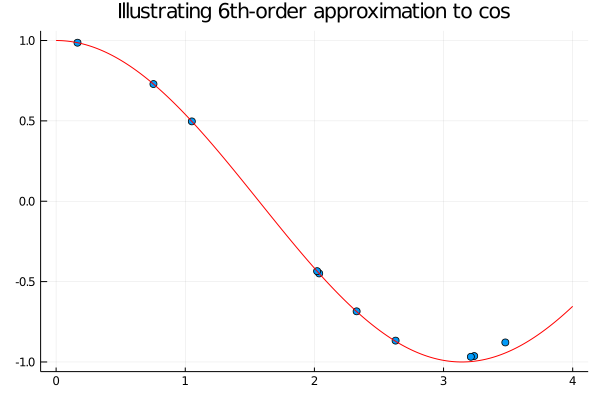

In [35]:
# now the plots
using Plots; gr()    # it is sometimes convenient to cram a line in this way

#first the plot of the approximation points
plot(x1, y1, line=:scatter, legend=:false, title="Illustrating 6th-order approximation to cos")

plot!(x2,y2; line = (:path, :red))   #then add the accurate line with plot!()

# 2. Using the data: a rough fit of the model parameters 

<h2>Outcome</h2>

After this lecture, you will be able to
- Extract total number of cases per epidemic day from a a run of our EVD model
- Use a plot to compare model values to observed values
- Use the interactive notebook to adjust $\lambda$, $\gamma$ and $S(0)$ 
- Estimate quickly a fairly good set of values by improving the fit of the model to the data

<h2>Total cases data: observation vs model</h2>

When one fits data to a model, the first thing is to ensure that the numbers from the model and the numbers from observation really represent the same thing.

In this case, the data reported in Wikipedia are of two kinds: total cases to date, and total deaths. Our model does not include deaths, so we cannot use that data. Moreover, in our model there is no explicit record of the number of cases. Therefore we have first to work out how to get our model to tell us what the total number of cases are.

Fortunately, that is not hard. The total cases to date is the number of people who have ever been infected. But every such person is either in the infected group currently or has moved to the removed group. So the total number of cases at time $t$ is $I(t) + R(t)$. We will use $C(t)$ to denote the modelled number of cases, and $W(t)$ for the reported number of cases from Wikipedia.

Let us rerun the model as we left it at the end of the previous lecture, with the estimates from there:

In [62]:
using Plots  # might as well start by loading Plots and choose to use the PyPlot backend
pyplot()

# now lets get the total cases data
using DelimitedFiles

EVDdata            = DelimitedFiles.readdlm("wikipediaEVDdatesconverted.csv", ',')
tvalsfromdata      = EVDdata[:,1]  # the epidemic day values
totalcasesfromdata = EVDdata[:, 2]    # we'll extract individual countries when we need them

# here's the function that drives the changes that happen every time step
function updateSIR(popnvector)       # exactly the same function as before
    susceptibles = popnvector[1];
    infecteds    = popnvector[2]; 
    removeds     = popnvector[3];
    newS = susceptibles - lambda*susceptibles*infecteds*dt
    newI = infecteds + lambda*susceptibles*infecteds*dt - gam*infecteds*dt  
    newR = removeds + gam*infecteds*dt
    return [newS newI newR] 
end

# this cell we need to run only once

updateSIR (generic function with 1 method)

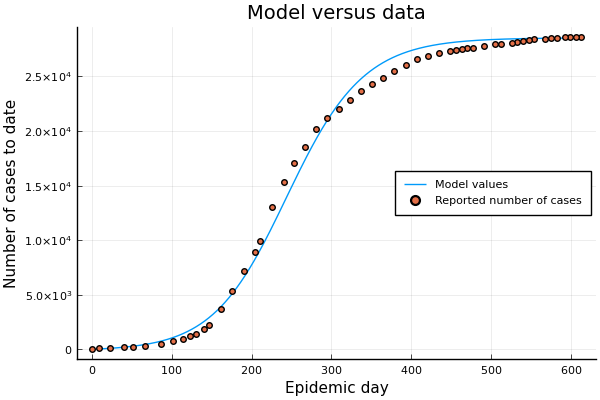

In [69]:
# set parameter values
lambda = 1.47*10^-6.   # infection rate parameter (assumes rates are per day)
gam = 0.125      # recovery rate parameter  (ditto)
dt = 0.5         # length of time step in days
tfinal = 610.;    # respecting community values: lowercase only in the names 

# set initial values (originally s0, lambda, gam, i = 22.*10^6., 2.3*10^-8., 0.05, 4. )
s0 = 1.0*10^5.     # initial susceptibles, note that we use the  type Float64 from the start
i0 = 20.          # initial infecteds; set this to 1. to  mimic an epidemic with an index case
r0 = 0.          # not always the case, of course


# initialise 
nsteps = round(Int64, tfinal/dt)    # note the use of round() with type Int64 to ensure that nsteps is an integer
resultvals = Array{Float64}(undef, nsteps+1, 3)  #initialise array of type Float64 to hold results
timevec = Array{Float64}(undef, nsteps+1)        # ... ditto for time values
resultvals[1,:] = [s0, i0, r0]  # ... and assign them to the first row
timevec[1] = 0.                 # also Float64, of course.

# the main loop over time steps
for step  = 1:nsteps
    resultvals[step+1, :] = updateSIR(resultvals[step, :])  # NB! pay careful attention to the rows being used
    timevec[step+1] = timevec[step] + dt
end

# make the plot
ivals = resultvals[:, 2]
rvals = resultvals[:, 3]
cvals = ivals + rvals     # assemble the model values for the case

plot(timevec, cvals,       # first the model's output s plotted as a line
label = "Model values",
xlabel = "Epidemic day",
ylabel = "Number of cases to date",
title = "Model versus data")

plot!(tvalsfromdata, totalcasesfromdata,
legend = :right,
line = :scatter,
label = "Reported number of cases")

There's quite a lot wrong here! Obviously the epidemic is going to far, too fast. We might also like to add "legend = :right" to stop it blocking things ... but we don't know where it is going  to be needed, so that would premature.

<h2>Interactively fitting the model to data using the notebook</h2>

We now interactively use the notebook, changing the values of $S(0)$, $\lambda$ and $\gamma$. In fact, it makes a difference what we set $I(0)$ as well, because that influences the  start of the modelled epidemic quite a bit. While in principle also $R(0)$ also matters, it is very small and hence it's influence is minimal.

It turns out that we have to adjust $S(0)$ especially, and accordingly the value of $\lambda$ needs to be adjusted as well.

No need to write out new code, we just navigate up to the cell where the model is run and plotted, and play there.

(The values of using $S(0) = 10^5$, $I(0) = 30$, $\gamma = 1/8$ and $\lambda = 1.47 \times 10^{−6}$ were found by extensive experimentation of this kind).

# Practice Quiz

 <h2 id="int"> Question 1      </h2>

In Julia a '!' character at the end of a function name usually indicates that:

a. The function returns an array

b. The function modifies the values of some of its arguments

c. The function has high priority when evaluating




Double-click __here__ for the solution.

<!-- Your answer is below:
 The function modifies the values of some of its arguments

Answer: B
--> 

 <h2 id="int"> Question 2      </h2>

Consider the following Julia code, Before you execute the code ensure that you have added the Plots package by executing the Pkg.add("Plots")

using Plots
            
f(x) = 5 * x^2 + 3 * x - 20
            
plot(f, -10:10) 
            
Which fragment of code will draw the x-axis onto the above plot of function f through the origin?


a. plot!(zero, -10, 10)

b. plot(zero, -10:10)

c. plot(0, -10:10)

Double-click __here__ for the solution.

<!-- Your answer is below:
using Plots
            
f(x) = 5 * x^2 + 3 * x - 20
            
plot(f, -10:10) 
    
plot!(zero, -10, 10)

Answer: A
--> 

 <h2 id="int"> Question 3      </h2>

The following Julia code defines a function f representing a parabola.

f(x) = -9*x^2 + 3*x + 6
using Plots

Which command will plot the function f in the range -2 to 2

a. plot(f)

b. plot(f, -2:2)

c. plot(-2, 2, f)

d. plot(f, -2, 2)

Double-click __here__ for the solution.

<!-- Your answer is below:
f(x) = -9*x^2 + 3*x + 6
using Plots
plot(f, -2, 2)
Answer: D
--> 